#### Surface fluxes from ERA-5
In this notebook, we are going to read in some ERA-5 Reanalysis fluxes, plot them, and then try to calculate them ourselves using the formulas from the textbook. 
More information about ERA-5 can be found [here](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5).

The data is available over the Nordic Seas, from 50˚N to 85˚N, and from 25˚W to 25˚E, and is the monthly average of May 2020. The spatial resolution is 0.25˚ x 0.25˚, which corresponds to about 27 km.

The data with all the variables is stored in a `netCDF`-file. Let's read in the contents of this file, using the `Dataset` function from the `netCDF4`-package:

In [75]:
from netCDF4 import Dataset

era_file = './ERA5_fluxes_202005.nc'
era_data = Dataset(era_file)
print(era_data.variables)

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (201,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (141,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used, 'si10': <class 'netCDF4._netCDF4.Variable'>
int16 si10(time, latitude, longitude)
    scale_factor: 0.00013505540624570827
    add_offset: 5.041132454463168
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre wind speed
unlimited dimensions: 
cur

We notice that there are variables containing the different fluxes:
* `slhf`: Surface latent heat flux
* `sshf`: Surface sensible heat flux
* `str` : Surface net thermal radiation (Longwave radiation)
* `ssr` : Surface net solar radiation (Shortwave radiation)

We also have the information that the values for the fluxes are in J m$^{-2}$. 

#### Plot the fluxes from ERA-5.
Let's start then by plotting the four surface heat fluxes from ERA-5. For that, we are going to use the `cartopy` and `matplotlib` packages. Since we will be plotting a lot of maps, it is useful to put this into a function that we can then readily use.

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# cartopy packages
from cartopy import crs as ccrs
import cartopy.feature as cfeatures
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# package to center a colormap around 0
from matplotlib.colors import TwoSlopeNorm

def my_map(ax,lon,lat,data,levels=100,cmap='Spectral',title='',clabel='[W m$^{-2}$]',extend='neither',cmap_center=0):
    # set map extent
    ax.set_extent([-25,25,50,85])

    # plot the data on the map
    im = ax.contourf(lon,lat,data,cmap=cmap,levels=levels,transform=ccrs.PlateCarree(),
                    norm = TwoSlopeNorm(cmap_center),extend=extend)
    
    # add some gridlines, land masses, coastlines and a title
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.add_feature(cfeatures.LAND,zorder=200,color='k')
    ax.coastlines(resolution='50m')
    ax.set_title(title)
    
    # add a colorbar
    plt.colorbar(im,orientation='horizontal',label=clabel)

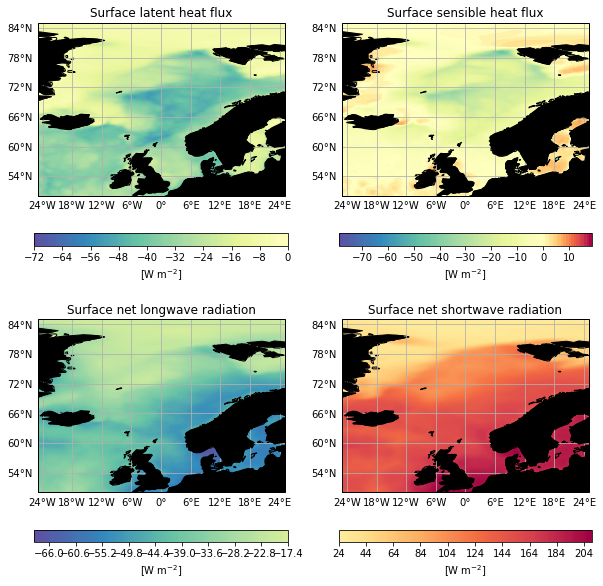

In [77]:
# We will create a map plot with 4 subplots, each showing one flux. We will go through the four
# variables with a loop.
variables = ['slhf','sshf','str','ssr']
# Let's also create a dictionary with the long names of the variables
variable_names = {'slhf': 'Surface latent heat flux', 'sshf': 'Surface sensible heat flux',
                 'str': 'Surface net longwave radiation', 'ssr': 'Surface net shortwave radiation'}

# For plotting, we need the longitude and latitude
lon = era_data.variables['longitude'][:]
lat = era_data.variables['latitude'][:]

# Create a meshgrid out of lon and lat
lon,lat = np.meshgrid(lon,lat)

# Because the fluxes are in J/m**2, let's convert them to W/m**2, by dividing them by
# the amount of seconds in May 2020 (remember W = J/s)
sec_per_month = 31*60*60

# open the figure
fig = plt.figure(figsize=(10,10))
for i,var in enumerate(variables): # loop over variables
    # read the data from the file
    var_data = era_data.variables[var][0,:,:] / sec_per_month
    
    # add a new subplot to the figure, and set the correct spatial extent
    ax = fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    my_map(ax,lon,lat,var_data,100,'Spectral_r',variable_names[var])

#### Calculate the fluxes on your own.
Let's try to calculate those fluxes above using the equations from the text book, that you used in the previous exercise. To do that, we are provided with the extra variables in the output:
* `sst`  : Sea surface temperature
* `tisr` : TOA (Top Of Atmosphere) incident solar radiation
* `tcc`  : Total cloud cover
* `si10` : 10 metre wind speed
* `fal`  : Forecast albedo
* `d2m`  : 2 metre dewpoint temperature
* `t2m`  : 2 metre temperature
* `msl` : Mean sea level pressure

As you will notice when looking at the equations, we also need the following additional variables:
* the water vapour pressure `e`
* the specific humidity `q`
* the saturated specific humidity `qs`

They are not in the regular output from ERA-5. But no worries, we can easily calculate them using empirical formulas from [Bolton  (1980)](https://journals.ametsoc.org/mwr/article/108/7/1046/62205/The-Computation-of-Equivalent-Potential). First, we can calculate the water vapor pressure `e` from the dewpoint `d2m`:

$e = 6.112exp(\frac{17.67 d2m}{d2m + 243.5})$.

Similarly, the saturated water vapour pressure `es` can be calculated with the same formula, but exchanging `d2m` by the regular temperature `t2m`.

The specific humidity `q` can be calculated from `e` and the pressure `msl`:

$q = \frac{0.622e}{msl - 0.378e}$.

Equally, the saturated specific humidity `qs` can be calculated using this formula and `es`.


In [78]:
msl = era_data.variables['msl'][0,:,:]/100 # pressure
t2m = era_data.variables['t2m'][0,:,:] # 2m temperature
d2m = era_data.variables['d2m'][0,:,:] # 2m dew point

T = t2m - 273.15
TD = d2m - 273.15
e = 6.112*np.exp((17.67*TD)/(TD + 243.5)) # calculate water vapor pressure
es = 6.112*np.exp((17.67*T)/(T + 243.5))# calculate saturated water vapor pressure
q = (0.622 * e)/(msl - (0.378 * e)) # calculate specific humidity
qs = (0.622 * es)/(msl - (0.378 * es)) # calculate saturated specific humidity

Now we have all the variables to be able to compute the fluxes on our own. Let's create a dictionary with the ERA fluxes and our calculated fluxes. We will fill the dictionary as we go along.

In [79]:
fluxes = {}

#### Shortwave radiation

Formula: Qs=(1-alpha)Qc(1-0.62*C+0.0019theta_N)
    
* alpha=albedo
* Qc=incoming clear-sky solar radiation at top of atmosphere
* C=monthly mean fractional cloud cover
* theta_N=noon solar elevation (degrees)

The solar elevation angle can be computed from the latitude and the solar declination, using [this](https://en.wikipedia.org/wiki/Solar_zenith_angle) formula (where h = 0 at noon). For the solar declination, we can assume 20˚ for May.


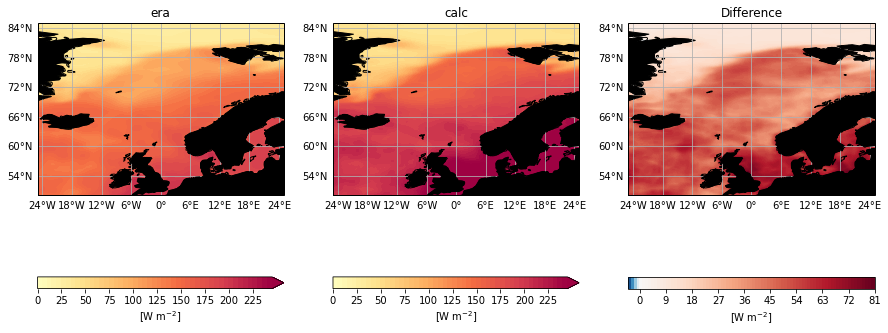

In [80]:
tisr = era_data.variables['tisr'][0,:,:]
tcc = era_data.variables['tcc'][0,:,:]
fal = era_data.variables['fal'][0,:,:]

# We can estimate the solar elevation by the following formula: 
# sin(alpha) = sin(Phi) sin(delta) + cos(Phi)cos(delta), with
# delta = 20˚, Phi = latitude
deg2rad = np.pi/180.
theta_N = np.arcsin(np.sin(lat*deg2rad)*np.sin(20*deg2rad) + np.cos(lat*deg2rad)*np.cos(20*deg2rad))/deg2rad

ssr_calc = (1-fal)*tisr*(1-0.62*tcc+0.0019*theta_N) / sec_per_month
ssr_era = era_data.variables['ssr'][0,:,:] / sec_per_month

# fill the fluxes dictionary with the shortwave fluxes
fluxes['ssr_era'] = ssr_era
fluxes['ssr_calc'] = ssr_calc
fluxes['ssr_diff'] = ssr_calc - ssr_era

# let's plot them and compare
levels = np.arange(0,250,5)

# open the figure
fig = plt.figure(figsize=(15,10))

for i,var in enumerate(['ssr_era','ssr_calc']):
    ax = fig.add_subplot(1,3,i+1,projection=ccrs.PlateCarree())
    my_map(ax,lon,lat,fluxes[var],levels,'Spectral_r',extend='max',title=var.split('_')[-1])
    
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
my_map(ax,lon,lat,fluxes['ssr_diff'],100,'RdBu_r',title='Difference')

#### Longwave radiation

Qb=epsilon*sigma_SB*(Tw)^4 (0.39-0.05(e)^0.5) (1-k*C^2) + 4epsilon*sigma_SB*(Tw)^3*(Tw-Ta)

* epsilon=emittance of sea surface =0.98
* sigma_SB=Stefan-Boltzmann constant = 5.67e-8
* Tw= SST in Kelvin (`sst`)
* Ta=air temperature in Kelvin (`t2m`)
* e=water vapor pressure (`e`)
* k= cloud cover coefficient (increase with latitude)
* C = fractional cloud cover (`tcc`)


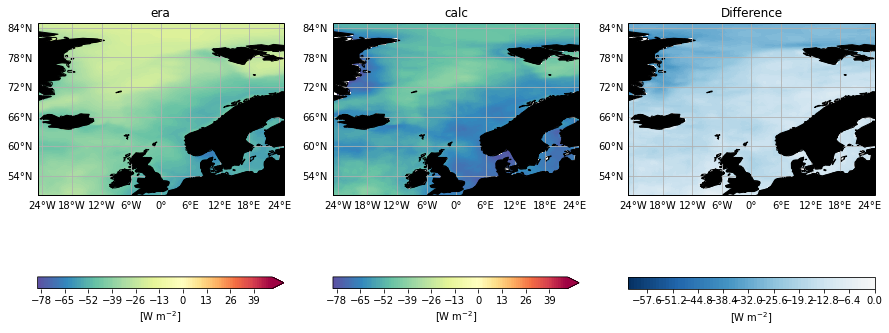

In [81]:
sst = era_data.variables['sst'][0,:,:]
sigma_SB = 5.67e-8
epsilon = 0.98
k = 0.7

str_calc = -epsilon*sigma_SB*(sst)**4 *(0.39-0.05*(e)**0.5)*(1-k*(tcc)**2) - 4*epsilon*sigma_SB*(sst)**3 *(sst-t2m)
str_era = era_data.variables['str'][0,:,:] / sec_per_month

# fill the fluxes dictionary with the shortwave fluxes
fluxes['str_era'] = str_era
fluxes['str_calc'] = str_calc
fluxes['str_diff'] = str_calc - str_era

# let's plot them and compare
levels = np.arange(-80,50,1)

# open the figure
fig = plt.figure(figsize=(15,10))

for i,var in enumerate(['str_era','str_calc']):
    ax = fig.add_subplot(1,3,i+1,projection=ccrs.PlateCarree())
    my_map(ax,lon,lat,fluxes[var],levels,'Spectral_r',extend='max',title=var.split('_')[-1])
    
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
my_map(ax,lon,lat,fluxes['str_diff'],100,'RdBu_r',title='Difference')

#### Latent heat flux:

Qe=Fe*L

* L = latent heat of evaporation =(2494-2.2`sst`) OBS:`sst` is water temperature in Celsius!
* Fe = rate of evaporation= rho*Ce*u*(`qs`-`q`)
* rho = air density (assume 1?)
* Ce = transfer coefficient for latent heat (set to 1.2 * Ch)
* Ch = transfer coefficient for sensible heat
* u = wind speed in m/s (this is our `si10`)
* `qs` = 98% of saturated specific humidity at the sea surface temperature (98% accounts for salt effect)
* `q` = measured specific humidity 



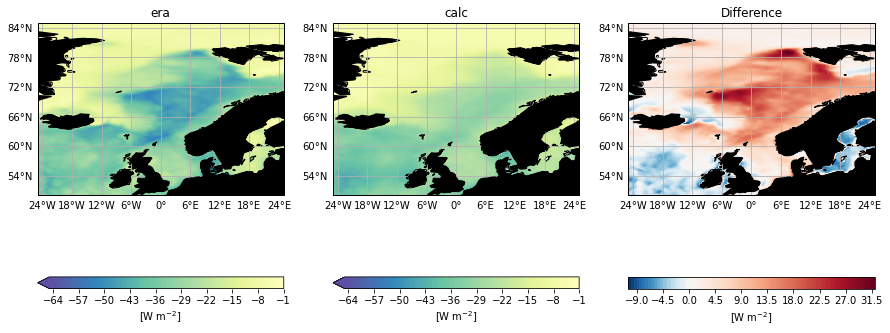

In [87]:
si10 = era_data.variables['si10'][0,:,:]
rho = 1.1
Ch = 1e-3
Ce = 1.2*Ch

# calculate the Latent heat of evaporation:
L = (2494 - 2.2*(sst-273.15)) * 1000
# Calculate the rate of evaporation
Fe = rho * Ce * si10 * (0.98*qs - q)

# Calculate the latent heat flux
slhf_calc = - Fe * L
slhf_era = era_data.variables['slhf'][0,:,:] / sec_per_month

# write on dictionary
fluxes['slhf_calc'] = slhf_calc
fluxes['slhf_era'] = slhf_era
fluxes['slhf_diff'] = slhf_calc - slhf_era

# let's plot them and compare
levels = np.arange(-65,0,1)

# open the figure
fig = plt.figure(figsize=(15,10))

for i,var in enumerate(['slhf_era','slhf_calc']):
    ax = fig.add_subplot(1,3,i+1,projection=ccrs.PlateCarree())
    my_map(ax,lon,lat,fluxes[var],levels,'Spectral_r',extend='min',title=var.split('_')[-1])
    
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
my_map(ax,lon,lat,fluxes['slhf_diff'],100,'RdBu_r',title='Difference')

#### Sensible heat flux:

Qh = rho * cp * Ch * u * (sst-(Ta+gamma*z))

* rho=air density
* cp=specific heat capacity for sea water
* Ch=transfer coefficient for sensible heat
* u=wind speed in m/s (our `si10`)
* sst=sea surface temperature
* Ta=air temperature (our `t2m`)
* z=height where Ta is measured
* gamma=adiabatic lapse rate of the air

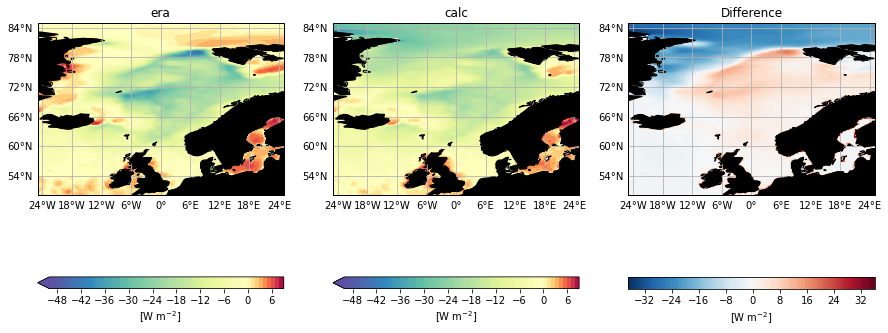

In [83]:
gamma = 9.8e-3
z = 2
cp = 1005

sshf_calc = - rho * cp * Ch * si10 * (sst - (t2m + gamma*z))
sshf_era = era_data.variables['sshf'][0,:,:] / sec_per_month

# write on dictionary
fluxes['sshf_calc'] = sshf_calc
fluxes['sshf_era'] = sshf_era
fluxes['sshf_diff'] = sshf_calc - sshf_era

# let's plot them and compare
levels = np.arange(-50,10,1)

# open the figure
fig = plt.figure(figsize=(15,10))

for i,var in enumerate(['sshf_era','sshf_calc']):
    ax = fig.add_subplot(1,3,i+1,projection=ccrs.PlateCarree())
    my_map(ax,lon,lat,fluxes[var],levels,'Spectral_r',extend='min',title=var.split('_')[-1])
    
ax = fig.add_subplot(1,3,3,projection=ccrs.PlateCarree())
my_map(ax,lon,lat,fluxes['sshf_diff'],100,'RdBu_r',title='Difference')